<h1 style="text-align:center;">Tesis - Optimización de Precios</h1>

In [1]:
#Instalación de libreria requerida para ploteo.

!pip install plotly

#### Importar Librerias

In [2]:
import random
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import gzip
import io
#import folium
#import branca
import warnings

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

from tqdm import tqdm

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', None)

### Funciones

In [3]:
# Se define función que cuenta la cantidad de valores nulos en cada columna de un DataFrame y se calcula
# el porcentaje de valores nulos por columna.

def contar_valores_nulos_con_porcentaje(dataframe):

    nulos_por_columna = dataframe.isnull().sum()
    porcentaje_nulos_por_columna = (nulos_por_columna / len(dataframe)) * 100

    resultados = pd.DataFrame({
        'Cantidad de Nulos': nulos_por_columna,
        'Porcentaje de Nulos (%)': porcentaje_nulos_por_columna
    })

    return resultados

#Se define función que elimina los valores atípicos de una columna específica en un DataFrame.
#La misma utiliza el método de rango intercuartílico para identificar valores atípicos, que son aquellos puntos de datos
#que caen fuera del rango definido por el primer cuartil (Q1) y el tercer cuartil (Q3).

def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df_filtered

#Se define función que elimina iterativamente los valores atípicos de una columna específica en un DataFrame hasta que
#no se encuentren más valores atípicos según el criterio del rango intercuartílico definido en la función "remove_outliers".

def remove_outliers_iteratively(df, column_name):
    df_clean = df.copy()
    while True:
        initial_len = len(df_clean)
        df_clean = remove_outliers(df_clean, column_name)
        final_len = len(df_clean)
        if initial_len == final_len:
            break
    return df_clean

In [4]:
#Lectura del conjunto de datos "Sep23_listings".

dflistings = pd.read_csv('Sep23_listings.csv.gz')

#### Diccionario dflistings

**id:** Identificador único de Airbnb para la lista.

**listing_url:** URL de publiación de alojamiento.

**scrape_id:** identificador único de recopilación de datos del alojamiento.

**last_scraped:** UTC. La fecha y hora en que esta lista fue recopilada.

**source:** "neighbourhood search"" o ""previous scrape"". "Neighbourhood search"" significa que el listado se encontró buscando en la ciudad, mientras que "previous scrape" significa que el listado se vio en otra extracción realizada en los últimos 65 días, y se confirmó que el listado todavía estaba disponible en el sitio de Airbnb.

**name:** Nombre del alojamiento.

**description:** Descripción detallada del alojamiento.

**neighborhood_overview:** Descripción del anfitrión del vecindario.

**picture_url:**URL a la imagen de tamaño regular alojado de Airbnb para la lista.

**host_id:** Identificador único de Airbnb para el host/usuario.

**host_url:** La página de Airbnb para el host.

**host_name:** Nombre del anfitrión. Por lo general, solo el primer nombre.

**host_since:** La fecha en que se creó el host/usuario. Para los anfitriones
 que son invitados de Airbnb, esta podría ser la fecha en que registraron como invitado.

**host_location:** La ubicación reportada por el anfitrión.

**host_about:** Descripción sobre el host.

**host_response_time:** tasa de tiempo de respuesta.

**host_response_rate:** tasa de puntaje de respuesta.

**host_acceptance_rate:** Esa tasa a la que un anfitrión acepta solicitudes de reserva.

**host_is_superhost:** identifica si es superhost (t) o no (f).

**host_thumbnail_url:** URL de imágen que representa al host.

**host_picture_URL:** URL de imágen de anfitrión.

**host_neighbourhood:** barrio al que pertenece el host.

**host_listings_count:** El número de alojamientos que tiene el host (por cálculos de Airbnb).

**host_total_listings_count:** El número de alojamientos que tiene el host (por cálculos de Airbnb).

**host_verifications:** define si el host está verificado o no.

**host_has_profile_pic:** define si el host tiene (t) o no (f) foto de perfil.

**host_identity_verified:** define si la identidad del host está verificada (t) o no (f).

**neighbourhood:** ciudad y país del alojamiento.

**neighbourhood_cleansed:** El vecindario geocodificado utilizando la latitud y la longitud contra los vecindarios según lo definido por los archivos de forma digital abiertos o públicos.

**neighbourhood_group_cleansed:** El grupo del vecindario geocodificado utilizando la latitud y la longitud contra los vecindarios según lo definido por los archivos de forma digital abiertos o públicos.

**latitude:** Utiliza la proyección del sistema geodésico mundial (WGS84) para la latitud y la longitud.

**longitude:** Utiliza la proyección del sistema geodésico mundial (WGS84) para la latitud y la longitud.

**property_type:** Tipo de propiedad seleccionada. Los hoteles y los bed y el desayuno son descritos como tales por sus anfitriones en este campo.

**room_type**: Todas las casas se agrupan en los siguientes tres tipos de habitaciones: lugar completo, habitación privada y habitación compartida.

- Lugar completo

Los lugares enteros son los mejores si buscas una casa fuera de casa. Con un lugar completo, tendrás todo el espacio para ti mismo. Esto generalmente incluye un dormitorio, un baño, una cocina y una entrada separada y dedicada. Los anfitriones deben tener en cuenta en la descripción si estarán en la propiedad o no (por ejemplo: El anfitrión ocupa el primer piso de la casa) y proporcionar más detalles sobre la lista.

- Cuartos privados

Las habitaciones privadas son excelentes para cuando prefiere un poco de privacidad y aún valoran una conexión local. Cuando reserve una habitación privada, tendrá su propia habitación privada para dormir y puede compartir algunos espacios con otros. Es posible que deba caminar por espacios interiores que otro anfitrión o invitado puede ocupar para llegar a su habitación.

- Habitaciones compartidas

Las habitaciones compartidas son para cuando no te importa compartir un espacio con otros. Cuando reserve una habitación compartida, estará durmiendo en un espacio que se comparte con otros y compartirá todo el espacio con otras personas. Las habitaciones compartidas son populares entre los viajeros flexibles que buscan nuevos amigos y estadías económicas.

**accommodates:** La capacidad máxima del alojamiento.

**bathrooms:** El número de baños en el alojamiento.

**bathrooms_text:** El número de baños en el alojamiento.En el sitio web de Airbnb, el campo de los baños ha evolucionado de un número a una descripción textual.

**bedrooms:** El número de dormitorios.

**beds:** El número de cama (s).

**amenities:**

**price:** Precio diario en moneda local.

**minimum_nights:** Número mínimo de estadía nocturna para el alojamiento(las reglas del calendario pueden ser diferentes).

**maximum_nights:** Número máximo de estadía nocturna para el alojamiento (las reglas del calendario pueden ser diferentes).

**minimum_minimum_nights:** El valor más pequeño de la noche del calendario (mirando 365 noches en el futuro).

**maximum_minimum_nights:** El valor mínimo más grande de la noche del calendario (mirando 365 noches en el futuro).

**minimum_maximum_nights:** El valor máximo más pequeño de la noche del calendario (mirando 365 noches en el futuro).

**maximum_maximum_nights:** El valor máximo más grande de la noche del calendario (mirando 365 noches en el futuro).

**minimum_nights_avg_ntm:** el valor promedio de mínimo de la noche del calendario (mirando 365 noches en el futuro).

**maximum_nights_avg_ntm:** El valor promedio de máximo de la noche del calendario (mirando 365 noches en el futuro).

**calendar_updated:** fecha de publiación de alojamiento.

**has_availability:** [t = verdadero; f = falso].

**availability_30:** La disponibilidad del alojamiento x días en el futuro según lo determine el calendario. Tenga en cuenta que un alojamiento puede no estar disponible porque ha sido reservado por un invitado o bloqueado por el anfitrión.

**availability_60:** La disponibilidad del alojamiento x días en el futuro según lo determine el calendario. Tenga en cuenta que un alojamiento puede no estar disponible porque ha sido reservado por un invitado o bloqueado por el anfitrión.

**availability_90:** La disponibilidad del alojamiento x días en el futuro según lo determine el calendario. Tenga en cuenta que un alojamiento puede no estar disponible porque ha sido reservado por un invitado o bloqueado por el anfitrión.

**availability_365:** La disponibilidad del alojamiento x días en el futuro según lo determine el calendario. Tenga en cuenta que un alojamiento puede no estar disponible porque ha sido reservado por un invitado o bloqueado por el anfitrión.

**calendar_last_scraped:** última fecha que se extrajeron los datos del alojamiento.

**number_of_reviews:** El número de reviews que tiene el alojamiento.

**number_of_reviews_ltm:** El número de reviews que tiene el alojamiento (en los últimos 12 meses).

**number_of_reviews_l30d:** El número de reviews que tiene el alojamiento (en los últimos 30 días).

**first_review:** La fecha de la primera/más antigua review.

**last_review:** La fecha de la última/nueva review.

**review_scores_rating:** calificación del alojamiento dada por los huéspedes.

**review_scores_accuracy:** métrica que define precisión de descripción del alojamiento vs realidad, en base a la experiencia del huésped.

**review_scores_cleanliness:** calificación de la limpieza del alojamiento dada por los huéspedes.

**review_scores_checkin:** calificación de ingreso al alojamiento dada por los huéspedes.

**review_scores_communication:** calificación de respuesta del host al húesped dada por este último.

**review_scores_location:** calificación de ubicación del alojamiento dada por el huésped.

**review_scores_value:** calificación de relación calidad/precio del alojamiento dada por el huésped.

**license:** La licencia/permiso/número de registro.

**instant_bookable:** [t = verdadero; f = falso]. Si el invitado puede reservar automáticamente el alojamiento sin el anfitrión que requiere aceptar su solicitud de reserva. Un indicador de una lista comercial.

**calculated_host_listings_count:** El número de alojamientos que el anfitrión tiene en la geografía de la ciudad/región.

**calculated_host_listings_count_entire_homes:** El número de alojamientos de hogar/apto que el anfitrión tiene en la geografía de la ciudad/región.

**calculated_host_listings_count_private_rooms:** El número de alojamientos de habitaciones privadas que el anfitrión tiene en la geografía de la ciudad/región.

**calculated_host_listings_count_shared_rooms:** El número de alojamientos de habitaciones compartidas que el anfitrión tiene en la geografía de la ciudad/región.

**reviews_per_month:** El número de revisiones que el alojamiento tiene durante la vida útil del alojamiento.

#### Diccionario dfcalendar

**listing_id:** Identificador único de Airbnb para la lista.

**date:** Fecha de calendario.

**available:** [t = verdadero; f = falso] Indica si el alojamiento está disponible (t) o no (f) en base a el dato de la fecha.

**price:** Precio del alojamiento por noche para la fecha dada.

**adjusted_price**

**minimum_nights:** Cantidad mínima de noches de reserva.

**maximum_nights:** Cantidad máxima de noches de reserva.

In [5]:
#Lectura del conjunto de datos "Sep23_calendar".

dfcalendar = pd.read_csv('Sep23_calendar.csv.gz')

In [6]:
#Lectura del conjunto de datos "Sep23_reviews".

dfreviews = pd.read_csv('Sep23_reviews.csv.gz')

In [7]:
dflistings.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,231497,https://www.airbnb.com/rooms/231497,20230922043705,2023-09-22,city scrape,Rental unit in Rio de Janeiro · ★4.73 · 1 bedr...,"This is a big studio at the end of Copacabana,...",NaN,https://a0.muscache.com/pictures/3582382/ee8ac...,1207700,https://www.airbnb.com/users/show/1207700,Maria Luiza,2011-09-25,"Rio de Janeiro, Brazil","Meu nome é Maria Luiza, adoro ajudar meus hósp...",within a few hours,100%,82%,f,https://a0.muscache.com/im/users/1207700/profi...,https://a0.muscache.com/im/users/1207700/profi...,Copacabana,4.0,8.0,"['email', 'phone']",t,t,NaN,Copacabana,NaN,-22.98238,-43.19215,Entire rental unit,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Hangers"", ""Body soap"", ""Elevator"", ""Bed line...",$180.00,3,89,3,3,89,89,3.0,89.0,NaN,t,0,0,0,204,2023-09-22,78,9,1,2011-11-17,2023-09-11,4.73,4.83,4.86,4.89,4.92,4.90,4.65,NaN,f,4,4,0,0,0.54
1,231516,https://www.airbnb.com/rooms/231516,20230922043705,2023-09-22,city scrape,Rental unit in Rio de Janeiro · ★4.71 · 1 bedr...,"Special location of the building, on Copacaban...",NaN,https://a0.muscache.com/pictures/3671683/d74b4...,1207700,https://www.airbnb.com/users/show/1207700,Maria Luiza,2011-09-25,"Rio de Janeiro, Brazil","Meu nome é Maria Luiza, adoro ajudar meus hósp...",within a few hours,100%,82%,f,https://a0.muscache.com/im/users/1207700/profi...,https://a0.muscache.com/im/users/1207700/profi...,Copacabana,4.0,8.0,"['email', 'phone']",t,t,NaN,Copacabana,NaN,-22.97787,-43.18792,Entire rental unit,Entire home/apt,4,NaN,NaN,1.0,1.0,"[""TV"", ""Kitchen"", ""Wifi"", ""Elevator"", ""Air con...",$350.00,3,89,3,3,89,89,3.0,89.0,NaN,t,0,0,1,113,2023-09-22,29,0,0,2011-11-02,2016-08-21,4.71,4.76,4.52,4.79,4.86,4.93,4.38,NaN,f,4,4,0,0,0.20
2,236991,https://www.airbnb.com/rooms/236991,20230922043705,2023-09-23,city scrape,Rental unit in Rio de Janeiro · ★4.89 · 1 bedr...,"Aconchegante, amplo, básico, arejado, iluminad...","Copacabana, apelidada a princesinha do mar, fa...",https://a0.muscache.com/pictures/5725a59b-147d...,1241662,https://www.airbnb.com/users/show/1241662,Nilda,2011-10-03,"Rio de Janeiro, Brazil",Hellow ! Im Nilda! I love Rio de Janeiro. ...,within an hour,100%,96%,t,https://a0.muscache.com/im/pictures/user/fea78...,https://a0.muscache.com/im/pictures/user/fea78...,Copacabana,2.0,2.0,"['email', 'phone']",t,t,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.96488,-43.17478,Entire rental unit,Entire home/apt,5,NaN,1 bath,1.0,4.0,"[""Clothing storage: wardrobe"", ""Public or shar...",$190.00,5,14,4,7,1125,1125,5.0,1125.0,NaN,t,14,21,51,51,2023-09-23,76,24,2,2014-03-03,2023-09-05,4.89,4.96,4.91,4.97,4.96,4.99,4.89,NaN,f,2,2,0,0,0.65
3,17878,https://www.airbnb.com/rooms/1787

In [8]:
dflistings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.196400e+04,3.196400e+04,3.196400e+04,31961.000000,31961.000000,0.0,31964.000000,31964.000000,31964.000000,0.0,24617.000000,31789.000000,31964.000000,31964.000000,31964.000000,31964.000000,31964.000000,31964.000000,31964.000000,31964.000000,0.0,31964.000000,31964.000000,31964.000000,31964.000000,31964.000000,31964.000000,31964.000000,23824.000000,23667.000000,23668.000000,23668.000000,23667.000000,23665.000000,23667.00000,0.0,31964.000000,31964.000000,31964.000000,31964.000000,23824.000000
mean,3.514699e+17,2.023092e+13,1.663077e+08,16.112450,27.273020,NaN,-22.967574,-43.251361,4.041265,NaN,1.783117,2.502690,4.740395,487.291515,4.366350,5.444813,605.104274,630.310412,4.642948,621.631082,NaN,16.451133,33.953416,54.673883,188.491960,19.938274,7.017426,0.584845,4.749393,4.800967,4.736847,4.881593,4.866827,4.861961,4.69660,NaN,8.839319,8.010825,0.707139,0.111719,0.974190
std,3.999653e+17,0.000000e+00,1.684315e+08,89.082309,134.207472,NaN,0.035182,0.100595,2.370380,NaN,1.067153,2.202994,23.653482,464.266309,20.312938,23.130296,485.705288,483.832226,20.594801,480.418557,NaN,11.989915,23.314947,33.898050,133.012558,40.676059,11.436773,1.167655,0.558515,0.400921,0.451490,0.321587,0.346049,0.322802,0.44839,NaN,23.515196,23.328498,1.735520,0.918342,1.127053
min,1.787800e+04,2.023092e+13,1.671000e+03,1.000000,1.000000,NaN,-23.073276,-43.723009,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.184739e+07,2.023092e+13,2.258631e+07,1.000000,1.000000,NaN,-22.984820,-43.310047,2.000000,NaN,1.000000,1.000000,1.000000,60.000000,1.000000,2.000000,90.000000,90.000000,2.000000,90.000000,NaN,3.000000,10.000000,24.000000,72.000000,0.000000,0.000000,0.000000,4.720000,4.760000,4.670000,4.890000,4.870000,4.850000,4.61000,NaN,1.000000,1.000000,0.000000,0.000000,0.170000
50%,5.261496e+07,2.023092e+13,8.693849e+07,2.000000,3.000000,NaN,-22.972860,-43.195670,4.000000,NaN,2.000000,2.000000,2.000000,365.000000,2.000000,3.000000,365.000000,365.000000,2.200000,365.000000,NaN,19.000000,39.000000,65.000000,174.000000,4.000000,2.000000,0.000000,4.910000,4.930000,4.890000,5.000000,5.000000,4.980000,4.81000,NaN,2.000000,1.000000,0.000000,0.000000,0.570000
75%,7.814279e+17,2.023092e+13,3.004090e+08,5.000000,7.000000,NaN,-22.956165,-43.185946,5.000000,NaN,2.000000,3.000000,3.000000,1125.000000,3.000000,5.000000,1125.000000,1125.000000,3.300000,1125.000000,NaN,29.000000,58.000000,88.000000,335.000000,20.000000,9.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,NaN,4.000000,3.000000,1.000000,0.000000,1.380000
max,9.855551e+17,2.023092e+13,5.379850e+08,1311.000000,1803.000000,NaN,-22.749690,-43.104400,16.000000,NaN,26.000000,91.000000,1125.000000,1825.000000,1125.000000,1125.000000,1825.000000,1825.000000,1125.000000,1825.000000,NaN,30.000000,60.000000,90.000000,365.000000,618.000000,133.000000,13.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,NaN,163.000000,159.000000,18.00000

In [9]:
dflistings.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                            

In [10]:
dflistings.shape

(31964, 75)

In [11]:
#Aplicación de función definida anteriormente para visualizar cantidad de valores nulos por variable y su equivalente en porcentaje sobre el total de datos.

contar_valores_nulos_con_porcentaje(dflistings)

,Cantidad de Nulos,Porcentaje de Nulos (%)
id,0,0.000000
listing_url,0,0.000000
scrape_id,0,0.000000
last_scraped,0,0.000000
source,0,0.000000
name,0,0.000000
description,659,2.061694
neighborhood_overview,15225,47.631711
picture_url,0,0.000000
host_id,0,0.000000


In [12]:
dfcalendar.head(5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,17878,2023-09-23,f,$265.00,$265.00,5.0,28.0
1,17878,2023-09-24,t,$265.00,$265.00,5.0,28.0
2,17878,2023-09-25,f,$290.00,$290.00,5.0,28.0
3,17878,2023-09-26,f,$290.00,$290.00,5.0,28.0
4,17878,2023-09-27,f,$290.00,$290.00,5.0,28.0


In [13]:
dfcalendar.describe()

,listing_id,minimum_nights,maximum_nights
count,1.166698e+07,1.166696e+07,1.166696e+07
mean,3.514704e+17,4.641293e+00,6.216723e+02
std,3.999590e+17,2.084305e+01,4.840862e+02
min,1.787800e+04,1.000000e+00,1.000000e+00
25%,2.184753e+07,2.000000e+00,9.000000e+01
50%,5.261722e+07,2.000000e+00,3.650000e+02
75%,7.814325e+17,3.000000e+00,1.125000e+03
max,9.855551e+17,1.125000e+03,1.825000e+03


In [14]:
dfcalendar.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

In [15]:
contar_valores_nulos_con_porcentaje(dfcalendar)

,Cantidad de Nulos,Porcentaje de Nulos (%)
listing_id,0,0.000000
date,0,0.000000
available,0,0.000000
price,0,0.000000
adjusted_price,0,0.000000
minimum_nights,15,0.000129
maximum_nights,15,0.000129


In [16]:
dfreviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,231497,726625,2011-11-17,1356783,Jenny,Es un apartastudio muy bien ubicado. Tiene lo ...
1,17878,64852,2010-07-15,135370,Tia,This apartment is in a perfect location -- two...
2,17878,76744,2010-08-11,10206,Mimi,we had a really great experience staying in Ma...
3,17878,91074,2010-09-06,80253,Jan,Staying in Max appartment is like living in a ...
4,17878,137528,2010-11-12,230449,Orene,In general very good and reasonable price.\r<b...


In [17]:
dfreviews.describe()

,listing_id,id,reviewer_id
count,6.373070e+05,6.373070e+05,6.373070e+05
mean,1.128101e+17,4.469503e+17,1.852193e+08
std,2.636175e+17,3.845078e+17,1.509693e+08
min,1.787800e+04,5.063600e+04,5.000000e+00
25%,9.642367e+06,5.381218e+08,5.029380e+07
50%,2.702873e+07,5.578677e+17,1.499738e+08
75%,4.870192e+07,8.100821e+17,3.004780e+08
max,9.825902e+17,9.862971e+17,5.381118e+08


In [18]:
dfreviews.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

In [19]:
contar_valores_nulos_con_porcentaje(dfreviews)

,Cantidad de Nulos,Porcentaje de Nulos (%)
listing_id,0,0.000000
id,0,0.000000
date,0,0.000000
reviewer_id,0,0.000000
reviewer_name,0,0.000000
comments,19,0.002981


### Preparación de Datos

#### Limpieza de Datos

#### Dataset Calendar

In [20]:
#Se convierte variable "price" a tipo integer y se eliminan los registros con valor "Na" ya que al ser la variable objetivo no se cuenta con la información
#base para la predicción.

dfcalendar['price'] = dfcalendar['price'].str.replace(r'[$,]', '', regex=True)

dfcalendar['price'] = pd.to_numeric(dfcalendar['price'], errors='coerce', downcast='integer')

dfcalendar = dfcalendar.dropna(subset=['price'])

In [21]:
#Se convierte variable "date" a tipo date.

dfcalendar['date'] = pd.to_datetime(dfcalendar['date'])

In [22]:
dfcalendar.shape

(11666976, 7)

In [23]:
#Se consultan tipos de variables nuevamente para confirmar que los cambios se aplicaron correctamente.

dfcalendar.dtypes

listing_id                 int64
date              datetime64[ns]
available                 object
price                      int32
adjusted_price            object
minimum_nights           float64
maximum_nights           float64
dtype: object

In [24]:
#Se decide eliminar las variables "adjusted_price", "minimum_nights" y "maximum_nights" debido a que la primera de estas tiene el mismo valor que la variable "price" en todos los casos,
#y las otras dos variables se encuentran en el dataset dflistings.

dfcalendar.drop(['adjusted_price', 'minimum_nights', 'maximum_nights'], axis=1, inplace=True)

In [25]:
dfcalendar

,listing_id,date,available,price
0,17878,2023-09-23,f,265
1,17878,2023-09-24,t,265
2,17878,2023-09-25,f,290
3,17878,2023-09-26,f,290
4,17878,2023-09-27,f,290
...,...,...,...,...
11666971,985555107088259155,2024-09-17,f,202
11666972,985555107088259155,2024-09-18,f,202
11666973,985555107088259155,2024-09-19,f,202
11666974,985555107088259155,2024-09-20,f,202


In [26]:
#Se verifica fecha mas antigua y reciente de los datos del dataset dfcalendar.

max_date = dfcalendar['date'].max()
min_date = dfcalendar['date'].min()

max_date_str = max_date.strftime("%Y-%m-%d")
min_date_str = min_date.strftime("%Y-%m-%d")

oracion = f"El rango de fechas en el calendario abarca desde el {min_date_str} hasta el {max_date_str}."

print(oracion)

El rango de fechas en el calendario abarca desde el 2023-09-22 hasta el 2024-09-21.


##### Dataset Listings

In [27]:
#Se convierte variable "price" a tipo integer.

dflistings['price'] = dflistings['price'].str.replace(r'[$,]', '', regex=True)

dflistings['price'] = pd.to_numeric(dflistings['price'], errors='coerce', downcast='integer')

In [28]:
#Se convierte variable bedrooms a tipo integer

dflistings['bedrooms'] = pd.to_numeric(dflistings['bedrooms'], errors='coerce')

dflistings['bedrooms'] = dflistings['bedrooms'].astype('Int64')


In [29]:
#Se analizaron las variables del dataset dflistings para determinar aquellas que a priori se entiende no tienen implicancia con la variable objetivo.
#Las conclusiones sobre que variables excluir fueron determinadas en base al conocimiento del negocio de Airbnb y a la experiencia como usuarios de la aplicación.

dflistings.drop(['scrape_id', 'name', 'description', 'host_id' ,'license', 'calendar_updated', 'bathrooms', 'neighbourhood', 'neighbourhood_group_cleansed', 'listing_url', 'scrape_id', 'source', 'picture_url', 'host_url', 'host_name', 'host_about', 'host_location', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_has_profile_pic', 'host_verifications', 'property_type', 'host_listings_count', 'host_total_listings_count' ,'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped', 'neighborhood_overview', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_checkin', 'review_scores_location', 'calculated_host_listings_count' ], axis=1, inplace=True)

In [30]:
contar_valores_nulos_con_porcentaje(dflistings)

,Cantidad de Nulos,Porcentaje de Nulos (%)
id,0,0.000000
last_scraped,0,0.000000
host_since,3,0.009386
host_response_time,6708,20.986109
host_response_rate,6708,20.986109
host_acceptance_rate,4781,14.957452
host_is_superhost,656,2.052309
host_identity_verified,3,0.009386
neighbourhood_cleansed,0,0.000000
latitude,0,0.000000


In [31]:
unique_values = dflistings['bathrooms_text'].unique()
unique_values

array(['1 bath', nan, '2 baths', '1.5 baths', '7 baths', '3 baths',
       '4 baths', '2.5 baths', '1 shared bath', '1 private bath',
       '5 shared baths', '3.5 baths', '2 shared baths', '0 shared baths',
       '4.5 baths', '0 baths', '1.5 shared baths', '5 baths',
       '2.5 shared baths', 'Shared half-bath', '10 baths', '8 baths',
       '6 baths', '6.5 baths', '3 shared baths', '3.5 shared baths',
       '5.5 baths', '4 shared baths', '7.5 baths', '15 baths',
       '8.5 baths', '20 shared baths', 'Half-bath', '4.5 shared baths',
       '6.5 shared baths', '15.5 baths', '12 baths', '6 shared baths',
       '10.5 baths', '7 shared baths', '9 baths', '11 baths', '16 baths',
       '8.5 shared baths', '9.5 baths', '5.5 shared baths', '11.5 baths',
       '8 shared baths', 'Private half-bath', '30 shared baths'],
      dtype=object)

In [32]:
#Se eliminan las filas donde falta información en la columna bathrooms_text, y luego se crea una nueva columna que indica con 1 o 0 si la palabra "shared" aparece en la columna bathrooms_text.
#Se toma esta decisión ya que se entiende que aquellos alojamientos donde el baño se comparte el precio debería ser menor.

dflistings.dropna(subset=['bathrooms_text'], inplace=True)

dflistings['shared'] = dflistings['bathrooms_text'].str.contains('shared').astype(int)

#Se inserta una nueva columna llamada bathrooms_count, ubicándola inmediatamente después de la columna bathrooms_text. Esta nueva columna contiene el número extraído de la columna bathrooms_text.

dflistings.insert(dflistings.columns.get_loc('bathrooms_text') + 1,'bathrooms_count', dflistings['bathrooms_text'].str.extract('(\d+)').astype(float))

# Elimina la columna 'bathrooms_text'

dflistings.drop(columns=['bathrooms_text'], inplace=True)

In [33]:
# 1 - True
# 0 - False

# Se filtran las filas de dflistings donde host_is_superhost es 't' o 'f', y luego se utiliza LabelEncoder para transformar estos valores en 0 o 1, donde el equivalente a 't' será 1 y el de 'f' será 0.
# Se aplica este cambio ya que es más adecuado para el análisis y entrenamiento de los modelos.

label_encoder = LabelEncoder()

filtered_rows = dflistings['host_is_superhost'].isin(['t', 'f'])

dflistings.loc[filtered_rows, 'host_is_superhost_encoded'] = label_encoder.fit_transform(dflistings.loc[filtered_rows, 'host_is_superhost'])

In [34]:
#Se observa que la cantidad de valores nulos de la variable 'host_is_superhost' representa el 2% de el total de observaciones que contiene, motivo por el cual se decide eliminar dichos
#registros.

dflistings = dflistings.dropna(subset=['host_is_superhost_encoded'])

##### Response Time - Rate - Reviews Scores

In [35]:
# Se elimina el símbolo de porcentaje, se convierten los valores a números flotantes, y luego se
# escalan dividiéndolos por 100 para convertirlos de porcentajes a valores decimales.

dflistings['host_response_rate'] = dflistings['host_response_rate'].str.rstrip('%').astype('float') / 100.0
dflistings['host_acceptance_rate'] = dflistings['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0


In [36]:
#Se observa que la variable 'room_type' está formada por observaciones de tipo object. Por esta razon se utilizó LabelEncoder para asignarle un valor numérico a cada una de estas.

label_encoder = LabelEncoder()

dflistings['room_type_encoded'] = label_encoder.fit_transform(dflistings['room_type'])


In [37]:
#Se convierte a tipo date las siguientes variables.

dflistings['last_scraped'] = pd.to_datetime(dflistings['last_scraped'])
dflistings['first_review'] = pd.to_datetime(dflistings['first_review'])
dflistings['last_review'] = pd.to_datetime(dflistings['last_review'])

### Transformación de los Datos

In [38]:
# La variable 'amenities' incluye las diferentes comodidades/servicios que el alojamiento ofrece separada cada una de ellos por coma. Se define función que cuente para cada alojamiento la cantidad de
#amenities que ofrece considerando como un amenitie cada registro separado por coma.

amenities_split = dflistings['amenities'].str.replace('"', '').str.split(",", expand=True)

amenity_counts = {}

for index, row in amenities_split.iterrows():
    for amenity in row:
        if amenity and amenity not in amenity_counts:
            amenity_counts[amenity] = 1
        elif amenity:
            amenity_counts[amenity] += 1


In [39]:
#Se cuenta la cantidad de amenities para cada alojamiento.

dflistings['amenity_count'] = amenities_split.apply(lambda x: len(x))

In [40]:
#Se renombra la columna id por "linsting_id".

dflistings = dflistings.rename(columns={'id': 'listing_id'})


In [41]:
#Se visualiza la cantidad de alojamientos por barrio con el objetivo de detectar aquellos barrios con mayor oferta.

dflistings.groupby('neighbourhood_cleansed').size().reset_index(name='count').sort_values(by='count', ascending=False).head(50)

,neighbourhood_cleansed,count
34,Copacabana,9230
8,Barra da Tijuca,3142
65,Ipanema,2967
68,Jacarepaguá,1557
112,Recreio dos Bandeirantes,1552
78,Leblon,1481
14,Botafogo,1328
122,Santa Teresa,1073
26,Centro,977
47,Flamengo,684


In [42]:
#Se cuentan los barrios y se decide reducir el conjunto de datos a aquellos barrios que contienen al menos 100 alojamientos.

conteo_por_barrio = dflistings['neighbourhood_cleansed'].value_counts()
barrios_validos = conteo_por_barrio[conteo_por_barrio >= 100].index
dflistings = dflistings[dflistings['neighbourhood_cleansed'].isin(barrios_validos)]

In [43]:
dfreviews['date'] = pd.to_datetime(dfreviews['date'])

# Se extrae el mes y el año de la columna 'date' del conjunto de datos de reviews.

dfreviews['year'] = dfreviews['date'].dt.year
dfreviews['month'] = dfreviews['date'].dt.month

# Se agrupa por listing_id

aggregated_reviews = dfreviews.groupby('listing_id').agg(
    first_review=('date', 'min'),
    last_review=('date', 'max'),
    num_reviews=('date', 'count')
).reset_index()

# Se agrupa por listing_id, año y mes, y se cuenta el número de reviews por mes

reviews_por_mes = dfreviews.groupby(['listing_id', 'year', 'month']).size().reset_index(name='num_reviews')

# Se agrupa por listing_id y se calcula el promedio de reviews por mes

promedio_reviews_por_mes = reviews_por_mes.groupby(['listing_id'])['num_reviews'].mean().reset_index(name='promedio_reviews_por_mes')

# Se combinan los DataFrames

aggregated_reviews = pd.merge(aggregated_reviews, promedio_reviews_por_mes, on='listing_id', how='left')

# Se completan los valores nulos en 'dflistings' con los valores de 'aggregated_reviews'

dflistings['first_review'].fillna(aggregated_reviews['first_review'], inplace=True)
dflistings['last_review'].fillna(aggregated_reviews['last_review'], inplace=True)
dflistings['reviews_per_month'].fillna(aggregated_reviews['promedio_reviews_por_mes'], inplace=True)

In [44]:
#Luego de completados los valores nulos que fueron posible, se eliminan aquellos que permanecen sin valor.

dflistings = dflistings.dropna(subset=['reviews_per_month'])

In [45]:
#Se exporta el dataset 'dflistings' en formato .csv.gz con el objetivo de comprimirlo y posteriormente pueda ser procesado con mayor agilidad.

output_buffer = io.StringIO()

dflistings.to_csv(output_buffer, index=False, encoding='utf-8')

csv_data = output_buffer.getvalue()

compressed_buffer = io.BytesIO()

with gzip.GzipFile(fileobj=compressed_buffer, mode='wb') as f_out:
    f_out.write(csv_data.encode('utf-8'))

with open('dflistings.csv.gz', 'wb') as f:
    f.write(compressed_buffer.getvalue())


In [46]:
#Se unifican los conjunto de datos dfcalendar y dflistings en base a la variable listing_id para comenzar a tabajar sobre un solo dataset denominado "df".

df = pd.merge(dfcalendar, dflistings.drop('price', axis=1), on='listing_id', how='inner')

In [47]:
#Se definen dos nuevos dataset (X e Y) a los cuales se le elimina la variable objetivo del dataset X y el dataset Y solo incluye dicha variable.

y_column = 'price'

X = df.drop([y_column], axis=1)
y = df[y_column]

In [48]:
#Se definen los conjuntos de datos de entrenamiento y testeo. El 80% de los datos se utilizar para el entrenamiento mientras que el restante 20% para el testeo.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
y_train =  pd.DataFrame(y_train, columns=['price'])
y_test =  pd.DataFrame(y_test, columns=['price'])

In [50]:
#Se crea una nueva variable denominada 'log_price' que muestra el valor equivalente del precio en escala logarítmica.
#Esta decisión fue tomada con el objetivo de reducir la varianza de la variable y también para reducir el impacto relativo de los datos atípicos.

y_train['log_price'] = np.log(y_train['price'])
y_test['log_price'] = np.log(y_test['price'])

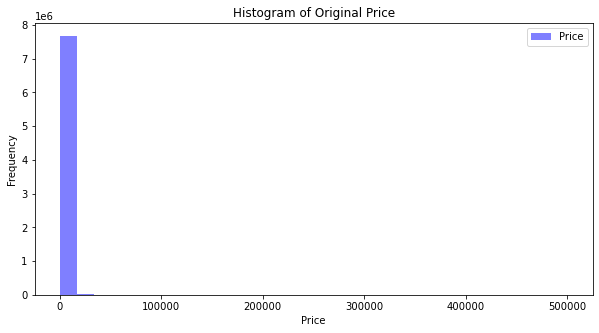

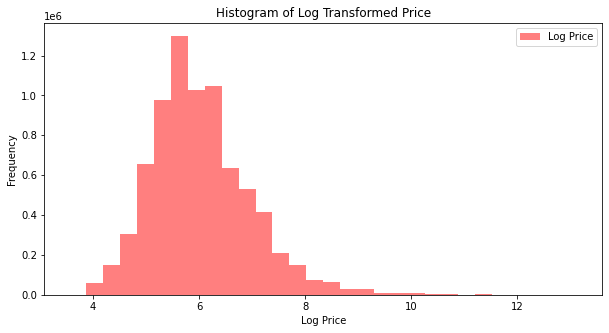

In [51]:
plt.figure(figsize=(10, 5))
plt.hist(y_train['price'], bins=30, color='blue', alpha=0.5, label='Price')
plt.legend()
plt.title('Histogram of Original Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(y_train['log_price'], bins=30, color='red', alpha=0.5, label='Log Price')
plt.legend()
plt.title('Histogram of Log Transformed Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()


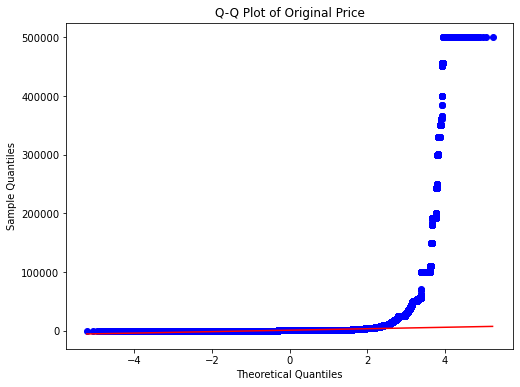

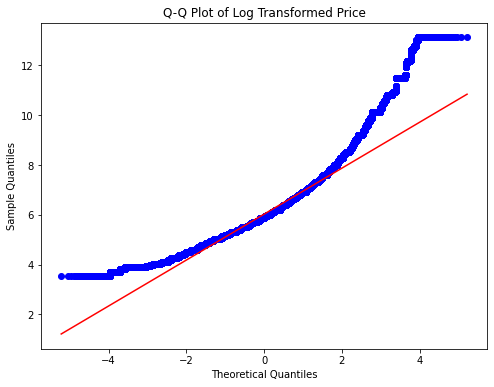

In [52]:
plt.figure(figsize=(8, 6))
stats.probplot(y_train['price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Original Price')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(y_train['log_price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log Transformed Price')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [53]:
#Se eliminan los outliers.

y_train_sin_outliers = remove_outliers_iteratively(y_train, 'log_price')
y_test_sin_outliers = remove_outliers_iteratively(y_test, 'log_price')

In [54]:
X_train.shape

(7705967, 39)

###### Host is Superhost

In [55]:
# Filtra los datos según la columna 'is_superhost' del conjunto de entrenamiento

is_superhost_true_x_train = X_train[X_train['host_is_superhost'] == "t"]
is_superhost_false_x_train = X_train[X_train['host_is_superhost'] == "f"]

# Suma cantidad de alojamientos con valores nulos en la columna host_response_time

host_response_time_superhost_true_x_train = is_superhost_true_x_train['host_response_time'].isnull().sum()
host_response_time_superhost_false_x_train = is_superhost_false_x_train['host_response_time'].isnull().sum()

# Suma cantidad de alojamientos con valores nulos en la columna host_response_rate

host_response_rate_superhost_true_x_train = is_superhost_true_x_train['host_response_rate'].isnull().sum()
host_response_rate_superhost_false_x_train = is_superhost_false_x_train['host_response_rate'].isnull().sum()

# Suma cantidad de alojamientos con valores nulos en la columna host_acceptance_rate

host_acceptance_rate_superhost_true_x_train = is_superhost_true_x_train['host_acceptance_rate'].isnull().sum()
host_acceptance_rate_superhost_false_x_train = is_superhost_false_x_train['host_acceptance_rate'].isnull().sum()

# Suma cantidad de alojamientos con valores nulos en la columna reviews_scores_rating

review_scores_rating_superhost_true_x_train = is_superhost_true_x_train['review_scores_rating'].isnull().sum()
review_scores_rating_superhost_false_x_train = is_superhost_false_x_train['review_scores_rating'].isnull().sum()

# Suma cantidad de alojamientos con valores nulos en la columna reviews_scores_value

review_scores_value_superhost_true_x_train = is_superhost_true_x_train['review_scores_value'].isnull().sum()
review_scores_value_superhost_false_x_train = is_superhost_false_x_train['review_scores_value'].isnull().sum()

In [56]:
# Filtra los datos según la columna 'is_superhost' del conjunto de testo

is_superhost_true_x_test = X_test[X_test['host_is_superhost'] == "t"]
is_superhost_false_x_test = X_test[X_test['host_is_superhost'] == "f"]

# Suma cantidad de alojamientos con valores nulos en la columna host_response_time

host_response_time_superhost_true_x_test = is_superhost_true_x_test['host_response_time'].isnull().sum()
host_response_time_superhost_false_x_test = is_superhost_false_x_test['host_response_time'].isnull().sum()

# Suma cantidad de alojamientos con valores nulos en la columna host_response_rate

host_response_rate_superhost_true_x_test = is_superhost_true_x_test['host_response_rate'].isnull().sum()
host_response_rate_superhost_false_x_test = is_superhost_false_x_test['host_response_rate'].isnull().sum()

# Suma cantidad de alojamientos con valores nulos en la columna host_acceptance_rate

host_acceptance_rate_superhost_true_x_test = is_superhost_true_x_test['host_acceptance_rate'].isnull().sum()
host_acceptance_rate_superhost_false_x_test = is_superhost_false_x_test['host_acceptance_rate'].isnull().sum()

# Suma cantidad de alojamientos con valores nulos en la columna reviews_scores_rating

review_scores_rating_superhost_true_x_test = is_superhost_true_x_test['review_scores_rating'].isnull().sum()
review_scores_rating_superhost_false_x_test = is_superhost_false_x_test['review_scores_rating'].isnull().sum()

# Suma cantidad de alojamientos con valores nulos en la columna reviews_scores_value

review_scores_value_superhost_true_x_test = is_superhost_true_x_test['review_scores_value'].isnull().sum()
review_scores_value_superhost_false_x_test = is_superhost_false_x_test['review_scores_value'].isnull().sum()

In [57]:
#Se realiza cuadro con el objetivo de comparar valores nulos de las variables mencionadas en base a si el alojamiento es super host o no para el cojunto de entrenamiento.

data = {
    'is_superhost': ['True', 'False'],
    'response_time_nulls': [host_response_time_superhost_true_x_train, host_response_time_superhost_false_x_train],
    'response_rate_nulls': [host_response_rate_superhost_true_x_train, host_response_rate_superhost_false_x_train],
    'acceptance_rate_nulls': [host_acceptance_rate_superhost_true_x_train, host_acceptance_rate_superhost_false_x_train],
    'review_scores_rating_nulls': [review_scores_rating_superhost_true_x_train, review_scores_rating_superhost_false_x_train],
    'review_scores_value_nulls': [review_scores_value_superhost_true_x_train, review_scores_value_superhost_false_x_train]
}

df_resultados_x_train = pd.DataFrame(data)
df_resultados_x_train


,is_superhost,response_time_nulls,response_rate_nulls,acceptance_rate_nulls,review_scores_rating_nulls,review_scores_value_nulls
0,True,41067,41067,898,63633,64219
1,False,1550257,1550257,1043715,1167684,1209541


In [58]:
#Se realiza cuadro con el objetivo de comparar valores nulos de las variables mencionadas en base a si el alojamiento es super host o no para el cojunto de testeo.

data = {
    'is_superhost': ['True', 'False'],
    'response_time_nulls': [host_response_time_superhost_true_x_test, host_response_time_superhost_false_x_test],
    'response_rate_nulls': [host_response_rate_superhost_true_x_test, host_response_rate_superhost_false_x_test],
    'acceptance_rate_nulls': [host_acceptance_rate_superhost_true_x_test, host_acceptance_rate_superhost_false_x_test],
    'review_scores_rating_nulls': [review_scores_rating_superhost_true_x_test, review_scores_rating_superhost_false_x_test],
    'review_scores_value_nulls': [review_scores_value_superhost_true_x_test, review_scores_value_superhost_false_x_test]
}

df_resultados_x_test = pd.DataFrame(data)
df_resultados_x_test

,is_superhost,response_time_nulls,response_rate_nulls,acceptance_rate_nulls,review_scores_rating_nulls,review_scores_value_nulls
0,True,10398,10398,197,15937,16081
1,False,387530,387530,261527,291951,302289


##### Host Response Time

In [59]:
unique_values = df['host_response_time'].unique()
unique_values

array(['within an hour', 'within a few hours', 'within a day', nan,
       'a few days or more'], dtype=object)

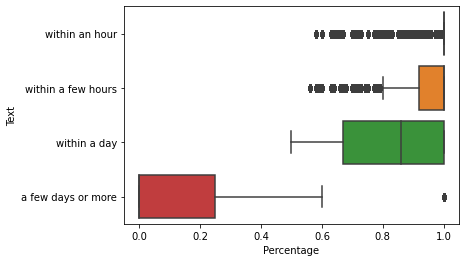

In [60]:
ax = sns.boxplot(x=df['host_response_rate'], y=df['host_response_time'])

mean_percentage = df['host_response_rate'].mean()

plt.xlabel('Percentage')
plt.ylabel('Text')
plt.show()

# #En el gráfico, se observan cuatro categorías de tiempo de respuesta:
# #"within an hour" (dentro de una hora) indica una distribución de tasas de respuesta con una mediana cercana a 1 (o 100%).
# #"a few days or more" (unos días o más), representado con una caja roja, tiene una mediana más baja, indicando que los anfitriones en esta categoría tienden a tener tasas de respuesta más bajas.
# #Las otras dos categorías, "within a day" (dentro de un día) y "within a few hours" (dentro de unas pocas horas) también muestran variabilidad en las tasas de respuesta.

##### Host Response Rate X Train

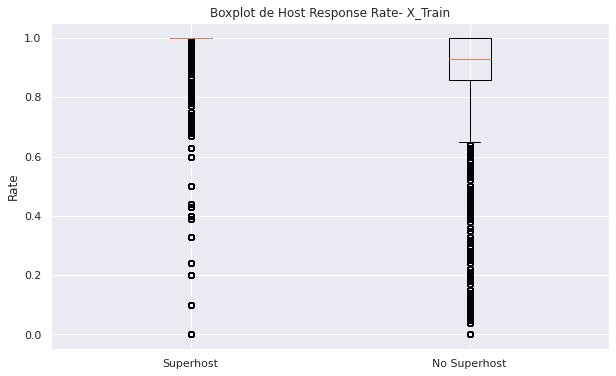

In [90]:
superhost_reviews_x_train = X_train[(X_train['host_is_superhost'] == 't') & (X_train['host_response_rate'].notna())]['host_response_rate']
non_superhost_reviews_x_train = X_train[(X_train['host_is_superhost'] == 'f') & (X_train['host_response_rate'].notna())]['host_response_rate']

plt.figure(figsize=(10, 6))
plt.boxplot([superhost_reviews_x_train, non_superhost_reviews_x_train], labels=['Superhost', 'No Superhost'])
plt.title('Boxplot de Host Response Rate- X_Train')
plt.ylabel('Rate')
plt.show()

#En el boxplot de los "Superhost", se observa lo siguiente:

#La caja (que representa el rango intercuartílico) es muy pequeña, lo que indica que la mayoría de los datos de los "Superhost" están muy concentrados en torno a una mediana alta, cercana a 1.

#Por otro lado, el boxplot de los "No Superhost" se muestra:
#Una caja más grande, lo que sugiere una mayor variabilidad en las puntuaciones de reviews.

#Ser "Superhost" está asociado con tener puntuaciones de reviews más altas y más consistentes en comparación con aquellos que no tienen esta distinción. Esto es consistente con las políticas de plataformas como Airbnb,
#donde los "Superhost" suelen ser anfitriones que proporcionan mejores experiencias, lo cual se refleja en sus puntuaciones de reviews.

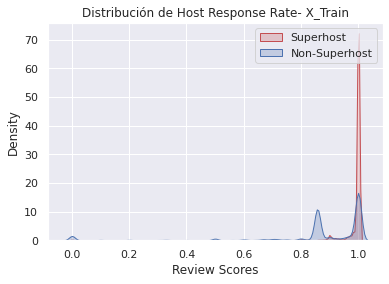

In [91]:
sns.set(style="darkgrid")

fig = sns.kdeplot(superhost_reviews_x_train, shade=True, color="r", label='Superhost')
fig = sns.kdeplot(non_superhost_reviews_x_train, shade=True, color="b", label='Non-Superhost')

plt.xlabel('Review Scores')
plt.ylabel('Density')
plt.title('Distribución de Host Response Rate- X_Train')

plt.legend()

plt.show()


#Para el grupo de Superhosts (línea roja):

#Se observa un pico pronunciado cercano a 1, lo que indica que hay una alta concentración de puntuaciones de reviews en torno a este valor.
#La distribución es bastante estrecha, mostrando que la mayoría de los Superhosts tienen puntuaciones de reviews muy altas y hay poca variabilidad entre ellos.

#Para el grupo de No Superhosts (línea azul):

#El pico es menos pronunciado y está también cerca de 1, pero hay una cola más larga hacia las puntuaciones más bajas.
#La distribución es más amplia, lo que sugiere que hay una mayor variabilidad en las puntuaciones de reviews entre los No Superhosts en comparación con los Superhosts.

#Se puede interpretar que los Superhosts tienden a tener puntuaciones de reviews más altas y más consistentes que los No Superhosts.

##### Host Response Rate X Test

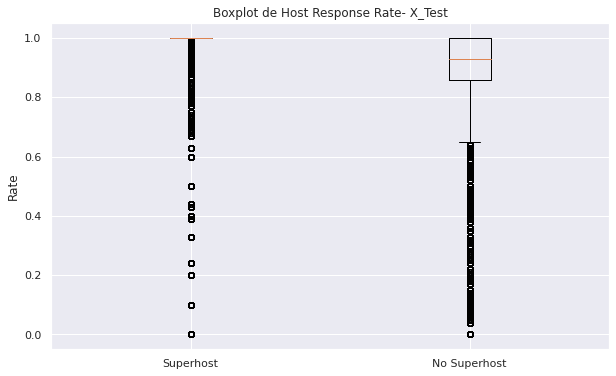

In [92]:
superhost_reviews_x_test = X_test[(X_test['host_is_superhost'] == 't') & (X_test['host_response_rate'].notna())]['host_response_rate']
non_superhost_reviews_x_test = X_test[(X_test['host_is_superhost'] == 'f') & (X_test['host_response_rate'].notna())]['host_response_rate']

plt.figure(figsize=(10, 6))
plt.boxplot([superhost_reviews_x_test, non_superhost_reviews_x_test], labels=['Superhost', 'No Superhost'])
plt.title('Boxplot de Host Response Rate- X_Test')
plt.ylabel('Rate')
plt.show()

#En el boxplot de los "Superhost", se observa lo siguiente:

#La caja (que representa el rango intercuartílico, o IQR) es muy pequeña, lo que indica que la mayoría de los datos de los "Superhost" están muy concentrados en torno a una mediana alta, cercana a 1.

#Por otro lado, el boxplot de los "No Superhost" se muestra:
#Una caja mucho más grande, lo que sugiere una mayor variabilidad en las puntuaciones de reviews.

#Ser "Superhost" está asociado con tener puntuaciones de reviews más altas y más consistentes en comparación con aquellos que no tienen esta distinción. Esto es consistente con las políticas de plataformas como Airbnb,
#donde los "Superhost" suelen ser anfitriones que proporcionan mejores experiencias, lo cual se refleja en sus puntuaciones de reviews.

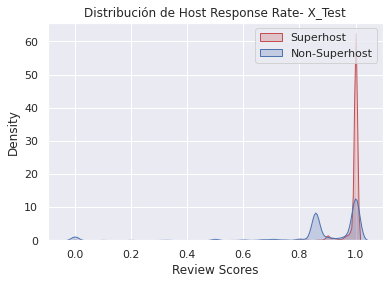

In [93]:
sns.set(style="darkgrid")

fig = sns.kdeplot(superhost_reviews_x_test, shade=True, color="r", label='Superhost')
fig = sns.kdeplot(non_superhost_reviews_x_test, shade=True, color="b", label='Non-Superhost')

plt.xlabel('Review Scores')
plt.ylabel('Density')
plt.title('Distribución de Host Response Rate- X_Test')

plt.legend()

plt.show()


#Para el grupo de Superhosts (línea roja):

#Se observa un pico pronunciado cercano a 1, lo que indica que hay una alta concentración de puntuaciones de reviews en torno a este valor.
#La distribución es bastante estrecha, mostrando que la mayoría de los Superhosts tienen puntuaciones de reviews muy altas y hay poca variabilidad entre ellos.

#Para el grupo de No Superhosts (línea azul):

#El pico es menos pronunciado y está también cerca de 1, pero hay una cola más larga hacia las puntuaciones más bajas.
#La distribución es más amplia, lo que sugiere que hay una mayor variabilidad en las puntuaciones de reviews entre los No Superhosts en comparación con los Superhosts.

#Se puede interpretar que los Superhosts tienden a tener puntuaciones de reviews más altas y más consistentes que los No Superhosts.

##### Host Acceptance Rate X Train

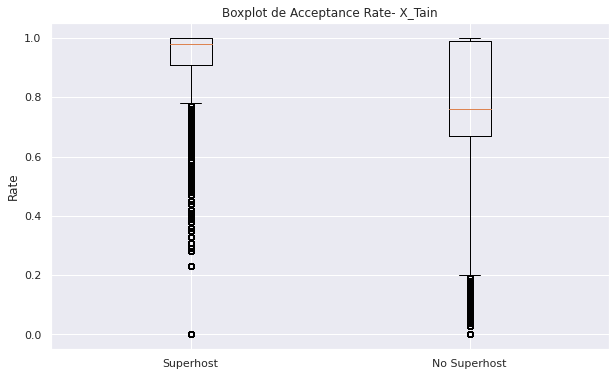

In [94]:
superhost_acceptance_x_train = X_train[(X_train['host_is_superhost'] == 't') & (X_train['host_acceptance_rate'].notna())]['host_acceptance_rate']
non_superhost_acceptance_x_train = X_train[(X_train['host_is_superhost'] == 'f') & (X_train['host_acceptance_rate'].notna())]['host_acceptance_rate']

plt.figure(figsize=(10, 6))
plt.boxplot([superhost_acceptance_x_train, non_superhost_acceptance_x_train], labels=['Superhost', 'No Superhost'], whis=1.5)

plt.title('Boxplot de Acceptance Rate- X_Tain')
plt.ylabel('Rate')
plt.show()

#Para los Superhosts, el boxplot muestra una caja centrada en torno a un valor alto, cercano a 1. Esto indica que los Superhosts tienden a tener tasas de aceptación consistentemente altas.
#El resto de la distribución de valores se extienden hacia abajo más significativamente, indicando variabilidad en las tasas de aceptación, pero con menos valores extremos en comparación con los No Superhosts.

#Por otro lado, el boxplot para los No Superhosts tiene un rango más amplio, que sugiere mayor variabilidad en las tasas de aceptación. La mediana parece ser más baja que la de los Superhosts,
#lo cual podría interpretarse como una tendencia general a tener tasas de aceptación más bajas.


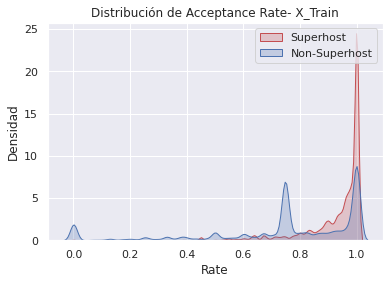

In [95]:
sns.set(style="darkgrid")

fig = sns.kdeplot(superhost_acceptance_x_train, shade=True, color="r", label='Superhost')
fig = sns.kdeplot(non_superhost_acceptance_x_train, shade=True, color="b", label='Non-Superhost')

plt.xlabel('Rate')
plt.ylabel('Densidad')
plt.title('Distribución de Acceptance Rate- X_Train')
plt.legend()

plt.show()

#Para el grupo de Superhosts (línea roja) se observa un pico agudo y pronunciado cerca del valor 1. Esto sugiere que una proporción significativa de Superhosts tiene puntajes de revisión muy altos, y la estrechez del pico indica una baja variabilidad en sus puntajes de revisión.
#El grupo de No Superhosts (línea azul), también muestra un pico cerca del valor 1, pero es menos pronunciado y la línea es más ancha, lo que indica una mayor variabilidad en sus puntajes de revisión.

#Donde las curvas son más altas, hay una mayor concentración de anfitriones con puntajes de revisión en ese rango específico.
#La superposición de las dos distribuciones permite una comparación directa, y se observa que los Superhosts tienden a agruparse más estrechamente alrededor de puntajes de revisión altos en comparación con los No Superhosts.

##### Host Acceptance Rate X Test

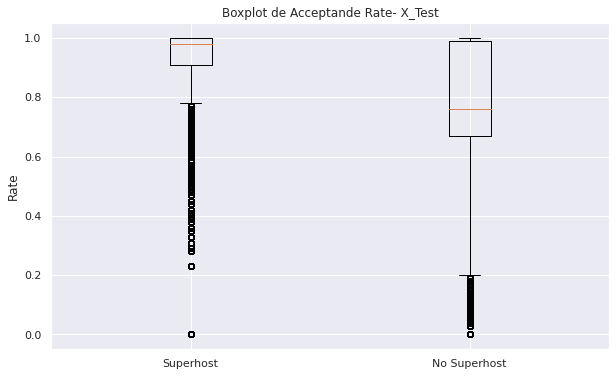

In [96]:
superhost_acceptance_x_test = X_test[(X_test['host_is_superhost'] == 't') & (X_test['host_acceptance_rate'].notna())]['host_acceptance_rate']
non_superhost_acceptance_x_test = X_test[(X_test['host_is_superhost'] == 'f') & (X_test['host_acceptance_rate'].notna())]['host_acceptance_rate']

plt.figure(figsize=(10, 6))
plt.boxplot([superhost_acceptance_x_test, non_superhost_acceptance_x_test], labels=['Superhost', 'No Superhost'], whis=1.5)

plt.title('Boxplot de Acceptande Rate- X_Test')
plt.ylabel('Rate')
plt.show()

#Para los Superhosts, el boxplot muestra una caja centrada en torno a un valor alto, cercano a 1. Esto indica que los Superhosts tienden a tener tasas de aceptación consistentemente altas.
#El resto de la distribución de valores se extienden hacia abajo más significativamente, indicando variabilidad en las tasas de aceptación, pero con menos valores extremos en comparación con los No Superhosts.

#Por otro lado, el boxplot para los No Superhosts tiene un rango más amplio, que sugiere mayor variabilidad en las tasas de aceptación. La mediana parece ser más baja que la de los Superhosts,
#lo cual podría interpretarse como una tendencia general a tener tasas de aceptación más bajas.


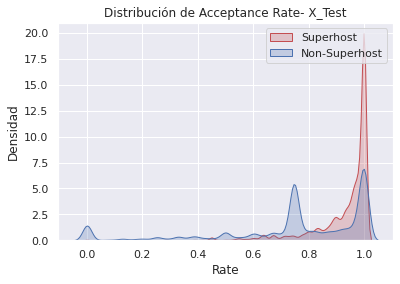

In [97]:
sns.set(style="darkgrid")

fig = sns.kdeplot(superhost_acceptance_x_test, shade=True, color="r", label='Superhost')
fig = sns.kdeplot(non_superhost_acceptance_x_test, shade=True, color="b", label='Non-Superhost')

plt.xlabel('Rate')
plt.ylabel('Densidad')
plt.title('Distribución de Acceptance Rate- X_Test')

plt.legend()

plt.show()

#Para el grupo de Superhosts (línea roja) se observa un pico agudo y pronunciado cerca del valor 1. Esto sugiere que una proporción significativa de Superhosts tiene puntajes de revisión muy altos, y la estrechez del pico indica una baja variabilidad en sus puntajes de revisión.
#El grupo de No Superhosts (línea azul), también muestra un pico cerca del valor 1, pero es menos pronunciado y la línea es más ancha, lo que indica una mayor variabilidad en sus puntajes de revisión.

#Donde las curvas son más altas, hay una mayor concentración de anfitriones con puntajes de revisión en ese rango específico.
#La superposición de las dos distribuciones permite una comparación directa, y se observa que los Superhosts tienden a agruparse más estrechamente alrededor de puntajes de revisión altos en comparación con los No Superhosts.

##### Review Scores Rating X Train

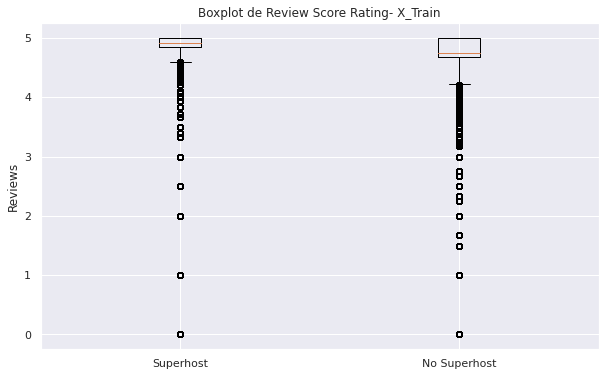

In [98]:
superhost_reviews_rating_x_train = X_train[(X_train['host_is_superhost'] == 't') & (X_train['review_scores_rating'].notna())]['review_scores_rating']
non_superhost_reviews_rating_x_train = X_train[(X_train['host_is_superhost'] == 'f') & (X_train['review_scores_rating'].notna())]['review_scores_rating']

plt.figure(figsize=(10, 6))
plt.boxplot([superhost_reviews_rating_x_train, non_superhost_reviews_rating_x_train], labels=['Superhost', 'No Superhost'], whis=1.5)

plt.title('Boxplot de Review Score Rating- X_Train')
plt.ylabel('Reviews')
plt.show()

#El boxplot para los Superhosts muestra una concentración de puntuaciones más alta y más estrecha cerca del máximo de 1.0, con menos valores atípicos, lo que indica que los Superhosts generalmente reciben puntuaciones de reseñas altas y consistentes.
#Por otro lado, el boxplot para los No Superhosts tiene un rango más amplio y una mediana más baja, lo que refleja una mayor variabilidad en las puntuaciones de las reseñas y una tendencia general a recibir puntuaciones más bajas que los Superhosts.

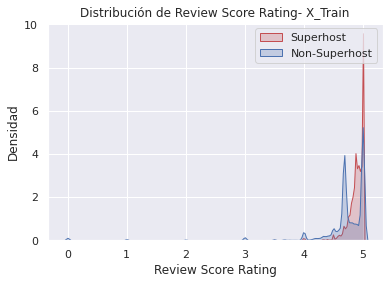

In [99]:
sns.set(style="darkgrid")

fig = sns.kdeplot(superhost_reviews_rating_x_train, shade=True, color="r", label='Superhost')
fig = sns.kdeplot(non_superhost_reviews_rating_x_train, shade=True, color="b", label='Non-Superhost')

plt.xlabel('Review Score Rating')
plt.ylabel('Densidad')
plt.title('Distribución de Review Score Rating- X_Train')

plt.legend()

plt.show()

#La línea roja (Superhost) y la línea azul (No Superhosts) indican la densidad de las puntuaciones de las reseñas en cada grupo.
#Ambas distribuciones parecen estar centradas alrededor de un valor alto, cercano a 5, lo cual sugiere que tanto los Superhosts como los No Superhosts reciben puntuaciones de reseñas generalmente altas.
#Sin embargo, se observa que la curva para los Superhosts es más estrecha y pico más pronunciado que la de los No Superhosts, lo que implica que las puntuaciones de los Superhosts son más consistentemente altas y menos dispersas que las de los No Superhosts.

#La presencia de un pico prominente en ambas curvas cerca de la puntuación máxima sugiere que la mayoría de las reseñas tienden a ser muy positivas para ambos grupos.
#Más allá de esto, la curva más ancha para los No Superhosts implica una mayor variabilidad en sus puntuaciones, indicando que es más probable que reciban puntuaciones de reseñas más bajas en comparación con los Superhosts.

##### Review Scores Rating X Test

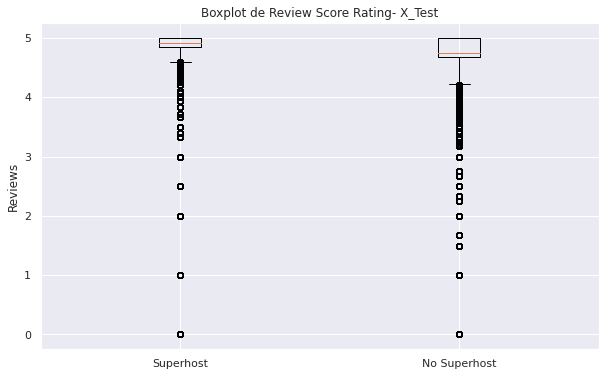

In [100]:
superhost_reviews_rating_x_test = X_test[(X_test['host_is_superhost'] == 't') & (X_test['review_scores_rating'].notna())]['review_scores_rating']
non_superhost_reviews_rating_x_test = X_test[(X_test['host_is_superhost'] == 'f') & (X_test['review_scores_rating'].notna())]['review_scores_rating']

plt.figure(figsize=(10, 6))
plt.boxplot([superhost_reviews_rating_x_test, non_superhost_reviews_rating_x_test], labels=['Superhost', 'No Superhost'], whis=1.5)

plt.title('Boxplot de Review Score Rating- X_Test')
plt.ylabel('Reviews')
plt.show()

#El boxplot para los Superhosts muestra una concentración de puntuaciones más alta y más estrecha cerca del máximo de 1.0, con menos valores atípicos, lo que indica que los Superhosts generalmente reciben puntuaciones de reseñas altas y consistentes.
#Por otro lado, el boxplot para los No Superhosts tiene un rango más amplio y una mediana más baja, lo que refleja una mayor variabilidad en las puntuaciones de las reseñas y una tendencia general a recibir puntuaciones más bajas que los Superhosts.

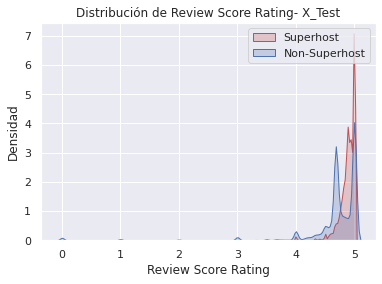

In [101]:
sns.set(style="darkgrid")

fig = sns.kdeplot(superhost_reviews_rating_x_test, shade=True, color="r", label='Superhost')
fig = sns.kdeplot(non_superhost_reviews_rating_x_test, shade=True, color="b", label='Non-Superhost')

plt.xlabel('Review Score Rating')
plt.ylabel('Densidad')
plt.title('Distribución de Review Score Rating- X_Test')
plt.legend()

plt.show()

#La línea roja (Superhost) y la línea azul (No Superhosts) indican la densidad de las puntuaciones de las reseñas en cada grupo.
#Ambas distribuciones parecen estar centradas alrededor de un valor alto, cercano a 5, lo cual sugiere que tanto los Superhosts como los No Superhosts reciben puntuaciones de reseñas generalmente altas.
#Sin embargo, se observa que la curva para los Superhosts es más estrecha y pico más pronunciado que la de los No Superhosts, lo que implica que las puntuaciones de los Superhosts son más consistentemente altas y menos dispersas que las de los No Superhosts.

#La presencia de un pico prominente en ambas curvas cerca de la puntuación máxima sugiere que la mayoría de las reseñas tienden a ser muy positivas para ambos grupos.
#Más allá de esto, la curva más ancha para los No Superhosts implica una mayor variabilidad en sus puntuaciones, indicando que es más probable que reciban puntuaciones de reseñas más bajas en comparación con los Superhosts.

##### Review Scores Value X Train

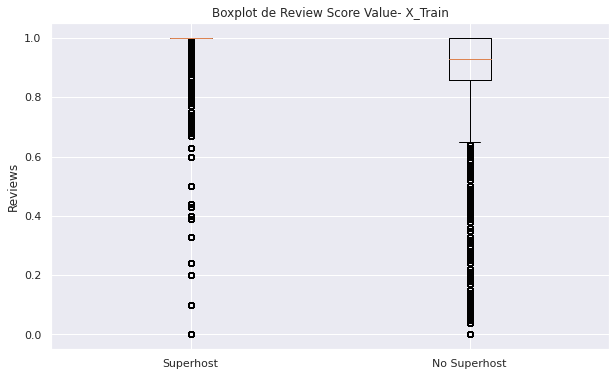

In [102]:
superhost_review_scores_val_x_train = X_train[(X_train['host_is_superhost'] == 't') & (X_train['review_scores_value'].notna())]['review_scores_value']
non_superhost_review_scores_val_x_train = X_train[(X_train['host_is_superhost'] == 'f') & (X_train['review_scores_value'].notna())]['review_scores_value']

plt.figure(figsize=(10, 6))
plt.boxplot([superhost_reviews_x_train, non_superhost_reviews_x_train], labels=['Superhost', 'No Superhost'])
plt.title('Boxplot de Review Score Value- X_Train')
plt.ylabel('Reviews')
plt.show()

#El boxplot vinculado a Superhost muestra una caja muy pequeña cerca del máximo de 1.0, lo que indica que la mayoría de los Superhosts reciben puntuaciones de reseñas altas y hay poca variabilidad entre ellos.
#El boxplot del lado derecho para los No Superhosts muestra una caja más grande y una mediana más baja, lo que indica que hay una variabilidad más significativa en sus puntuaciones de reseñas y una tendencia general hacia puntuaciones más bajas.

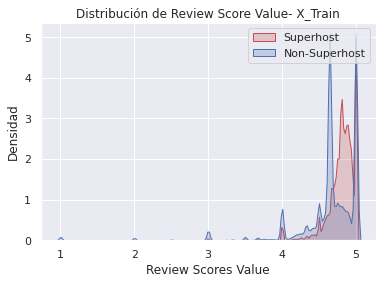

In [103]:
sns.set(style="darkgrid")

fig = sns.kdeplot(superhost_review_scores_val_x_train, shade=True, color="r", label='Superhost')
fig = sns.kdeplot(non_superhost_review_scores_val_x_train, shade=True, color="b", label='Non-Superhost')

plt.xlabel('Review Scores Value')
plt.ylabel('Densidad')
plt.title('Distribución de Review Score Value- X_Train')

plt.legend()

plt.show()

#La curva roja representa a los Superhosts y la curva azul a los No Superhosts. Ambas curvas muestran picos cerca de la puntuación máxima, lo que indica que hay una tendencia general de recibir reseñas positivas en ambos grupos.
#Sin embargo, la curva de los Superhosts es más estrecha y tiene un pico más alto en comparación con la de los No Superhosts, lo cual sugiere que las puntuaciones de los Superhosts son más consistentemente altas y menos dispersas.
#Además la curva de los No Superhosts es más ancha y tiene una altura menor, indicando una mayor variabilidad en sus puntuaciones de reseñas y la posibilidad de obtener puntuaciones más bajas con más frecuencia.

##### Review Scores Value X Test

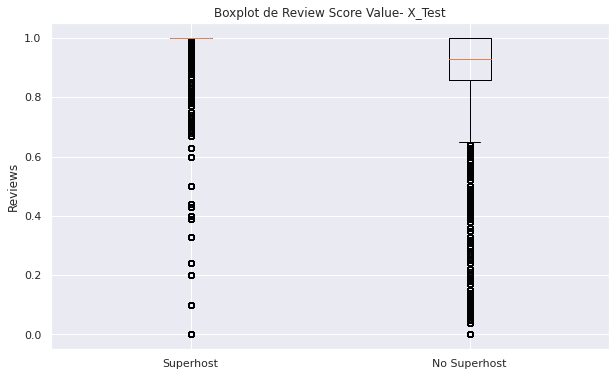

In [104]:
superhost_review_scores_val_x_test = X_test[(X_test['host_is_superhost'] == 't') & (X_test['review_scores_value'].notna())]['review_scores_value']
non_superhost_review_scores_val_x_test = X_test[(X_test['host_is_superhost'] == 'f') & (X_test['review_scores_value'].notna())]['review_scores_value']

plt.figure(figsize=(10, 6))
plt.boxplot([superhost_reviews_x_test, non_superhost_reviews_x_test], labels=['Superhost', 'No Superhost'])
plt.title('Boxplot de Review Score Value- X_Test')
plt.ylabel('Reviews')
plt.show()

#El boxplot vinculado a Superhost muestra una caja muy pequeña cerca del máximo de 1.0, lo que indica que la mayoría de los Superhosts reciben puntuaciones de reseñas altas y hay poca variabilidad entre ellos.
#El boxplot del lado derecho para los No Superhosts muestra una caja más grande y una mediana más baja, lo que indica que hay una variabilidad más significativa en sus puntuaciones de reseñas y una tendencia general hacia puntuaciones más bajas.

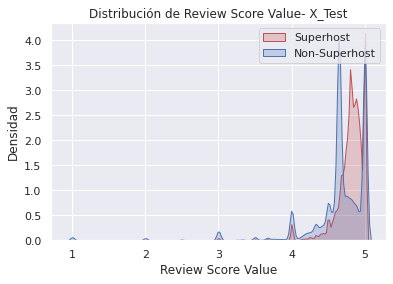

In [105]:
sns.set(style="darkgrid")

fig = sns.kdeplot(superhost_review_scores_val_x_test, shade=True, color="r", label='Superhost')
fig = sns.kdeplot(non_superhost_review_scores_val_x_test, shade=True, color="b", label='Non-Superhost')

plt.xlabel('Review Score Value')
plt.ylabel('Densidad')
plt.title('Distribución de Review Score Value- X_Test')
plt.legend()

plt.show()

#La curva roja representa a los Superhosts y la curva azul a los No Superhosts. Ambas curvas muestran picos cerca de la puntuación máxima, lo que indica que hay una tendencia general de recibir reseñas positivas en ambos grupos.
#Sin embargo, la curva de los Superhosts es más estrecha y tiene un pico más alto en comparación con la de los No Superhosts, lo cual sugiere que las puntuaciones de los Superhosts son más consistentemente altas y menos dispersas.
#Además la curva de los No Superhosts es más ancha y tiene una altura menor, indicando una mayor variabilidad en sus puntuaciones de reseñas y la posibilidad de obtener puntuaciones más bajas con más frecuencia.

In [77]:
# Calcula la media de cada columna para cada grupo del conjunto de train
mean_host_response_rate_true_x_train = is_superhost_true_x_train['host_response_rate'].mean()
mean_host_response_rate_false_x_train = is_superhost_false_x_train['host_response_rate'].mean()

mean_host_acceptance_rate_true_x_train = is_superhost_true_x_train['host_acceptance_rate'].mean()
mean_host_acceptance_rate_false_x_train = is_superhost_false_x_train['host_acceptance_rate'].mean()

mean_review_scores_rating_true_x_train = is_superhost_true_x_train['review_scores_rating'].mean()
mean_review_scores_rating_false_x_train = is_superhost_false_x_train['review_scores_rating'].mean()

mean_review_scores_val_true_x_train = is_superhost_true_x_train['review_scores_value'].mean()
mean_review_scores_val_false_x_train = is_superhost_false_x_train['review_scores_value'].mean()

In [78]:
# Calcula la media de cada columna para cada grupo del conjunto de test
mean_host_response_rate_true_x_test = is_superhost_true_x_test['host_response_rate'].mean()
mean_host_response_rate_false_x_test = is_superhost_false_x_test['host_response_rate'].mean()

mean_host_acceptance_rate_true_x_test = is_superhost_true_x_test['host_acceptance_rate'].mean()
mean_host_acceptance_rate_false_x_test = is_superhost_false_x_test['host_acceptance_rate'].mean()

mean_review_scores_rating_true_x_test = is_superhost_true_x_test['review_scores_rating'].mean()
mean_review_scores_rating_false_x_test = is_superhost_false_x_test['review_scores_rating'].mean()

mean_review_scores_val_true_x_test = is_superhost_true_x_test['review_scores_value'].mean()
mean_review_scores_val_false_x_test = is_superhost_false_x_test['review_scores_value'].mean()

In [79]:
# Reemplazar valores nulos en 'host_response_rate' con la media de esta variable.
X_train['host_response_rate'] = X_train['host_response_rate'].fillna(X_train['host_is_superhost'].map({'t': mean_host_response_rate_true_x_train, 'f': mean_host_response_rate_false_x_train}))

# Reemplazar valores nulos en 'host_acceptance_rate' con la media de esta variable
X_train['host_acceptance_rate'] = X_train['host_acceptance_rate'].fillna(X_train['host_is_superhost'].map({'t': mean_host_acceptance_rate_true_x_train, 'f': mean_host_acceptance_rate_false_x_train}))

# Reemplazar valores nulos en 'review_scores_rating' con la media de esta variable
X_train['review_scores_rating'] = X_train['review_scores_rating'].fillna(X_train['host_is_superhost'].map({'t': mean_review_scores_rating_true_x_train, 'f': mean_review_scores_rating_false_x_train}))

# Reemplazar valores nulos en 'review_scores_value' con la media de esta variable
X_train['review_scores_value'] = X_train['review_scores_value'].fillna(X_train['host_is_superhost'].map({'t': mean_review_scores_val_true_x_train, 'f': mean_review_scores_val_false_x_train}))


In [80]:
# Reemplazar valores nulos en 'host_response_rate'
X_test['host_response_rate'] = X_test['host_response_rate'].fillna(X_test['host_is_superhost'].map({'t': mean_host_response_rate_true_x_test, 'f': mean_host_response_rate_false_x_test}))

# Reemplazar valores nulos en 'host_acceptance_rate'
X_test['host_acceptance_rate'] = X_test['host_acceptance_rate'].fillna(X_test['host_is_superhost'].map({'t': mean_host_acceptance_rate_true_x_test, 'f': mean_host_acceptance_rate_false_x_test}))

# Reemplazar valores nulos en 'review_scores_rating'
X_test['review_scores_rating'] = X_test['review_scores_rating'].fillna(X_test['host_is_superhost'].map({'t': mean_review_scores_rating_true_x_test, 'f': mean_review_scores_rating_false_x_test}))

# Reemplazar valores nulos en 'review_scores_value'
X_test['review_scores_value'] = X_test['review_scores_value'].fillna(X_test['host_is_superhost'].map({'t': mean_review_scores_val_true_x_test, 'f': mean_review_scores_val_false_x_test}))


In [81]:
#Se aplica imputación bajo el modelo KNN a la variable 'bedroom' en el conjunto de entrenamiento con el objetivo de completar los valores nulos
#en base a el valor de las 5 observaciones mas cercanas.

chunk_size = 1000
total_chunks = len(X_train) // chunk_size + 1

imputed_values = []

imputer = KNNImputer(n_neighbors=5)

for i in tqdm(range(total_chunks)):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(X_train))

    chunk_data = X_train.iloc[start_idx:end_idx][['bedrooms']]

    chunk_data_imputed = imputer.fit_transform(chunk_data)

    imputed_values.append(chunk_data_imputed)

imputed_bedrooms = np.vstack(imputed_values)

X_train['bedrooms'] = np.round(imputed_bedrooms).astype(int)


100%|██████████| 7706/7706 [00:48<00:00, 159.26it/s]


In [82]:
#Se aplica imputación bajo el modelo KNN a la variable 'bedroom' en el conjunto de testeo con el objetivo de completar los valores nulos
#en base a el valor de las 5 observaciones mas cercanas.

chunk_size = 1000
total_chunks = len(X_test) // chunk_size + 1

imputed_values = []

imputer = KNNImputer(n_neighbors=5)

for i in tqdm(range(total_chunks)):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(X_test))

    chunk_data = X_test.iloc[start_idx:end_idx][['bedrooms']]

    chunk_data_imputed = imputer.fit_transform(chunk_data)

    imputed_values.append(chunk_data_imputed)

imputed_bedrooms = np.vstack(imputed_values)

X_test['bedrooms'] = np.round(imputed_bedrooms).astype(int)


100%|██████████| 1927/1927 [00:12<00:00, 160.53it/s]


In [83]:
X_train['year'] = X_train['date'].dt.year

X_train['month'] = X_train['date'].dt.month

X_train['numero_dia'] = X_train['date'].dt.dayofweek + 1  # Suma 1 para que el lunes sea 1, martes 2, etc.

X_train['last_scraped'] = pd.to_datetime(X_train['last_scraped'])
X_train['host_since'] = pd.to_datetime(X_train['host_since'])
X_train['antiguedad'] = (X_train['last_scraped'] - X_train['host_since']).dt.days

X_test['year'] = X_test['date'].dt.year

X_test['month'] = X_test['date'].dt.month

X_test['numero_dia'] = X_test['date'].dt.dayofweek + 1  # Suma 1 para que el lunes sea 1, martes 2, etc.

X_test['last_scraped'] = pd.to_datetime(X_test['last_scraped'])
X_test['host_since'] = pd.to_datetime(X_test['host_since'])
X_test['antiguedad'] = (X_test['last_scraped'] - X_test['host_since']).dt.days

#Para cada barrio único en la variable neighbourhood_cleansed se le asocia un número entero único en una nueva variable denominada neighbourhood_cleansed_encoded.
label_encoder = LabelEncoder()

X_train['neighbourhood_cleansed_encoded'] = label_encoder.fit_transform(X_train['neighbourhood_cleansed'])

label_encoder = LabelEncoder()

X_train['host_identity_verified_encoded'] = label_encoder.fit_transform(X_train['host_identity_verified'])

#Para cada barrio único en la variable neighbourhood_cleansed se le asocia un número entero único en una nueva variable denominada neighbourhood_cleansed_encoded.
label_encoder = LabelEncoder()

X_test['neighbourhood_cleansed_encoded'] = label_encoder.fit_transform(X_test['neighbourhood_cleansed'])

label_encoder = LabelEncoder()

X_test['host_identity_verified_encoded'] = label_encoder.fit_transform(X_test['host_identity_verified'])

In [84]:
#Se unifican conjunto de datos sin valores atípicos en la variable objetivo.

train_df_sin_outliers = pd.merge(X_train, y_train_sin_outliers, left_index=True, right_index=True, how='inner')
test_df_sin_outliers = pd.merge(X_test, y_test_sin_outliers, left_index=True, right_index=True, how='inner')

In [85]:
#Se unifican en un solo conjunto de datos denominado 'df' ambos dataset con el objetivo de trabajar sobre un único conjunto en la exploración de los datos.

df = pd.concat([train_df_sin_outliers, test_df_sin_outliers], axis=0)

In [86]:
#Se eliminan las variables que se entienden no tienen mayor incidencia en la determinación de la variable objetivo definida.

df.drop(['listing_id', 'last_scraped', 'host_since', 'host_response_time', 'host_identity_verified', 'host_identity_verified_encoded' , 'beds', 'minimum_nights', 'maximum_nights', 'has_availability', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'instant_bookable' ], axis=1, inplace=True)

In [87]:
#Se eliminan las variables que se entienden no tienen mayor incidencia en la determinación de la variable objetivo definida.

X_train.drop(['listing_id', 'last_scraped', 'host_since', 'host_response_time', 'host_identity_verified', 'host_identity_verified_encoded' , 'beds', 'minimum_nights', 'maximum_nights', 'has_availability', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'instant_bookable' ], axis=1, inplace=True)
X_test.drop(['listing_id', 'last_scraped', 'host_since', 'host_response_time', 'host_identity_verified', 'host_identity_verified_encoded' , 'beds', 'minimum_nights', 'maximum_nights', 'has_availability', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'instant_bookable' ], axis=1, inplace=True)

In [88]:
#Finalmente se imputa valor 0 a aquellos registros que aún sigan siendo nulos.

dflistings.fillna(0, inplace=True)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [89]:
def convert_and_compress_to_csv_gz(dataset, output_filename):
    output_buffer = io.StringIO()

    dataset.to_csv(output_buffer, index=False, encoding='utf-8')

    csv_data = output_buffer.getvalue()

    compressed_buffer = io.BytesIO()

    with gzip.GzipFile(fileobj=compressed_buffer, mode='wb') as f_out:
        total_size = len(csv_data.encode('utf-8'))
        pbar = tqdm(total=total_size, unit='B', unit_scale=True)

        f_out.write(csv_data.encode('utf-8'))
        pbar.update(total_size)

        pbar.close()

    with open(output_filename, 'wb') as f:
        f.write(compressed_buffer.getvalue())

convert_and_compress_to_csv_gz(df, 'df.csv.gz')

convert_and_compress_to_csv_gz(dflistings, 'dflistings.csv.gz')

convert_and_compress_to_csv_gz(X_train, 'X_train.csv.gz')

convert_and_compress_to_csv_gz(X_test, 'X_test.csv.gz')

convert_and_compress_to_csv_gz(y_train, 'y_train.csv.gz')

convert_and_compress_to_csv_gz(y_test, 'y_test.csv.gz')


100%|██████████| 6.47G/6.47G [02:44<00:00, 39.3MB/s]
100%|██████████| 19.1M/19.1M [00:00<00:00, 36.8MB/s]
100%|██████████| 5.17G/5.17G [02:12<00:00, 39.0MB/s]
100%|██████████| 1.29G/1.29G [00:32<00:00, 39.2MB/s]
100%|██████████| 171M/171M [00:14<00:00, 12.1MB/s]
100%|██████████| 42.7M/42.7M [00:03<00:00, 12.1MB/s]
